In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import src.shapes as shapes
import pandas as pd
import os
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
import datetime as dt
from sklearn.neighbors import KDTree
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.02f}'.format)
from geopy.distance import geodesic
from shapely.ops import linemerge
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
import contextily as ctx
from src.api import *
from src.gtfs_segments import GTFS_shape_processor
import matplotlib.pyplot as plt
import bisect


In [54]:
class BusSpeedCaclulator:
    
    def __init__(self, GTFS_rt_df, GTFS_dict, GTFS_segments, in_crs = 4326, out_crs = 2263):
        self.buses_raw = GTFS_rt_df
        self.GTFS_dict = GTFS_dict
        self.in_crs = in_crs
        self.out_crs = out_crs
        self.GTFS_segments = GTFS_segments

    def _prep_buses(self, buses):
        buses = gpd.GeoDataFrame(
            buses,
            geometry=gpd.points_from_xy(buses["vehicle.position.longitude"], buses["vehicle.position.latitude"]),
            crs=self.in_crs
        )

        buses = buses.to_crs(self.out_crs)
        buses = buses.drop("id", axis = 1)
        buses.columns = buses.columns.str.replace("vehicle.", '').str.replace('trip.', '').str.replace('position.', '')
        buses["unique_trip_id"] = buses["trip_id"] + buses["id"] + buses["start_date"]
        buses = buses.merge(self.GTFS_dict['trips.txt'][["trip_id", "shape_id"]].drop_duplicates())

        return buses
    
    def _prep_full_strings(self):

        full_strings = self.GTFS_segments.groupby("shape_id")["geometry"].apply(lambda x: linemerge(list(x.dropna()))).reset_index().set_index("shape_id")

        return full_strings.groupby('shape_id')['geometry'].first().to_dict()
    
    def _add_position_on_route_vectorized(self, buses, full_strings_dict):

        points = buses['geometry']
        shape_ids = buses['shape_id']
        
        distances = np.zeros(len(buses))
        positions = np.zeros(len(buses))
        
        for i, (point, shape_id) in enumerate(zip(points, shape_ids)):
            if pd.notnull(point) and shape_id in full_strings_dict:
                line = full_strings_dict[shape_id]
                distances[i] = point.distance(line)
                positions[i] = line.project(point)
            else:
                distances[i] = np.nan
                positions[i] = np.nan
        
        buses['distance_to_line'] = distances
        buses['position_on_line'] = positions

        return buses
        
    def _longest_increasing_subsequence(self, df):
        """
        Finds the longest increasing subsequence in the 'position_on_line' column of a DataFrame.
        
        Parameters:
        df (pd.DataFrame): DataFrame sorted by 'timestamp' and containing 'position_on_line' column.
        
        Returns:
        pd.DataFrame: DataFrame containing the longest increasing subsequence.
        """
        positions = df['position_on_line'].values
        n = len(positions)
        
        # Arrays to hold the end positions and predecessors
        tails = []
        predecessors = [-1] * n
        indices = []
        
        for i in range(n):
            pos = positions[i]
            # Find the insertion point
            idx = bisect.bisect_left(tails, pos)
            
            if idx == len(tails):
                tails.append(pos)
                indices.append(i)
            else:
                tails[idx] = pos
                indices[idx] = i
            
            if idx > 0:
                predecessors[i] = indices[idx - 1]
        
        # Reconstruct the longest increasing subsequence
        lis_indices = []
        k = indices[-1]
        while k >= 0:
            lis_indices.append(k)
            k = predecessors[k]
        lis_indices.reverse()
        
        # Return the DataFrame rows corresponding to the longest increasing subsequence
        return df.iloc[lis_indices].reset_index(drop=True)
    
    def create_trip_speeds(self):

        full_strings = self._prep_full_strings()
        buses = self._prep_buses(self.buses_raw)
        buses_with_speeds = self._add_position_on_route_vectorized(buses, full_strings)
        
        trip_ids = buses_with_speeds.unique_trip_id.drop_duplicates()
        buses_with_speeds = buses_with_speeds.set_index("unique_trip_id")
        
        trip_speeds = []
        print(len(trip_ids))
        for trip_id in trip_ids:
            try: 
                trip_df = buses_with_speeds.loc[trip_id]
                trip_df = self._longest_increasing_subsequence(trip_df.sort_values(by = "timestamp"))
                trip_df["epoch_timestamp"] = trip_df["timestamp"].astype(int) // 10**9

                trip_segments = self.GTFS_segments.loc[trip_df["shape_id"].iloc[0]]
                trip_segments["interpolated_time"] = pd.to_datetime(np.round(np.interp(trip_segments["projected_position"], trip_df["position_on_line"], trip_df["epoch_timestamp"])), unit='s')
                trip_segments["time_elapsed"] = trip_segments["interpolated_time"].diff().dt.total_seconds()
                trip_segments["speed_mph"] = (trip_segments["segment_length"] / trip_segments["time_elapsed"]) * 0.681818
                trip_segments["unique_trip_id"] = trip_id
                trip_segments = trip_segments.drop("geometry", axis = 1).replace([np.inf, -np.inf], np.nan).dropna()

                trip_speeds.append(trip_segments)
            except Exception as e:
                print(e)
                print(trip_id)
                continue

        return pd.concat(trip_speeds)


In [109]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import linemerge
import bisect
import logging

class BusSpeedCalculator:
    """
    A class to calculate bus speeds along segments of a transit network using GTFS real-time data.
    """

    def __init__(self, GTFS_rt_df, GTFS_dict, GTFS_segments, in_crs=4326, out_crs=2263):
        """
        Initialize the BusSpeedCalculator.

        Parameters:
        GTFS_rt_df (pd.DataFrame): The real-time GTFS data as a pandas DataFrame.
        GTFS_dict (dict): A dictionary containing GTFS data files as DataFrames.
        GTFS_segments (gpd.GeoDataFrame): GeoDataFrame of GTFS segments with geometries.
        in_crs (int): Input Coordinate Reference System (CRS) code. Default is 4326.
        out_crs (int): Output CRS code. Default is 2263.
        """
        self.buses_raw = GTFS_rt_df
        self.GTFS_dict = GTFS_dict
        self.in_crs = in_crs
        self.out_crs = out_crs
        self.GTFS_segments = GTFS_segments

    def prep_buses(self):
        """
        Prepare the buses DataFrame by converting it to a GeoDataFrame,
        transforming coordinate systems, and merging with GTFS trip data.

        Returns:
        gpd.GeoDataFrame: Prepared buses GeoDataFrame.
        """
        buses = self.buses_raw.copy()

        buses = gpd.GeoDataFrame(
            buses,
            geometry=gpd.points_from_xy(
                buses["vehicle.position.longitude"],
                buses["vehicle.position.latitude"]
            ),
            crs=self.in_crs
        ).drop("id", axis = 1)

        buses = buses.to_crs(self.out_crs)

        buses.columns = buses.columns.str.replace("vehicle.", '', regex=False)
        buses.columns = buses.columns.str.replace('trip.', '', regex=False)
        buses.columns = buses.columns.str.replace('position.', '', regex=False)

        required_columns = ['trip_id', 'id', 'start_date']
        for col in required_columns:
            if col not in buses.columns:
                raise KeyError(f"Required column '{col}' is missing in the buses DataFrame.")

        buses["unique_trip_id"] = (
            buses["trip_id"].astype(str) +
            buses["id"].astype(str) +
            buses["start_date"].astype(str)
        )

        # Merge with 'trips.txt' to get 'shape_id'
        buses = buses.merge(
            self.GTFS_dict['trips.txt'][["trip_id", "shape_id"]].drop_duplicates(),
            on='trip_id',
            how='inner'
        )

        return buses

    def prep_full_strings(self):
        """
        Prepare full strings (merged LineStrings) for each shape_id.

        Returns:
        dict: Dictionary mapping shape_id to merged LineString geometry.
        """
        # Group by 'shape_id' and merge LineStrings
        full_strings = self.GTFS_segments.groupby("shape_id")["geometry"].apply(
            lambda x: linemerge(list(x.dropna()))
        )
        return full_strings.to_dict()

    def add_position_on_route(self, buses, full_strings_dict):
        """
        Add 'distance_to_line' and 'position_on_line' to buses GeoDataFrame.

        Parameters:
        buses (gpd.GeoDataFrame): GeoDataFrame of bus positions.
        full_strings_dict (dict): Dictionary mapping shape_id to merged LineString geometry.

        Returns:
        gpd.GeoDataFrame: Updated buses GeoDataFrame with additional columns.
        """
        # Initialize arrays
        distances = np.empty(len(buses))
        positions = np.empty(len(buses))
        distances.fill(np.nan)
        positions.fill(np.nan)

        # Loop over buses
        for i, (point, shape_id) in enumerate(zip(buses['geometry'], buses['shape_id'])):
            if pd.notnull(point) and shape_id in full_strings_dict:
                line = full_strings_dict[shape_id]
                distances[i] = point.distance(line)
                positions[i] = line.project(point)

        # Assign to DataFrame
        buses['distance_to_line'] = distances
        buses['position_on_line'] = positions

        return buses

    def _longest_increasing_subsequence(self, df):
        """
        Finds the longest increasing subsequence in the 'position_on_line' column of a DataFrame.

        Parameters:
        df (pd.DataFrame): DataFrame sorted by 'timestamp' and containing 'position_on_line' column.

        Returns:
        pd.DataFrame: DataFrame containing the longest increasing subsequence.
        """
        positions = df['position_on_line'].values
        n = len(positions)

        # Arrays to hold the end positions and predecessors
        tails = []
        predecessors = [-1] * n
        indices = []

        for i in range(n):
            pos = positions[i]
            # Find the insertion point
            idx = bisect.bisect_left(tails, pos)

            if idx == len(tails):
                tails.append(pos)
                indices.append(i)
            else:
                tails[idx] = pos
                indices[idx] = i

            if idx > 0:
                predecessors[i] = indices[idx - 1]

        # Reconstruct the longest increasing subsequence
        lis_indices = []
        k = indices[-1]
        while k >= 0:
            lis_indices.append(k)
            k = predecessors[k]
        lis_indices.reverse()

        # Return the DataFrame rows corresponding to the longest increasing subsequence
        return df.iloc[lis_indices].reset_index(drop=True)

    def create_trip_speeds(self):
        """
        Create trip speeds by processing bus positions and calculating speeds along segments.

        Returns:
        pd.DataFrame: DataFrame containing speed information for each trip segment.
        """
        full_strings = self.prep_full_strings()
        buses = self.prep_buses()
        buses_with_speeds = self.add_position_on_route(buses, full_strings)

        trip_ids = buses_with_speeds["unique_trip_id"].drop_duplicates()
        buses_with_speeds = buses_with_speeds.set_index("unique_trip_id")
        trip_speeds = []
        print(f"Processing {len(trip_ids)} trips...")
        for trip_id in trip_ids:
            trip_df = buses_with_speeds.loc[trip_id]
            if isinstance(trip_df, pd.Series):
                trip_df = trip_df.to_frame().T

            if trip_df.shape[0] < 10:
                continue
            trip_df = trip_df.sort_values(by="timestamp")
            trip_df = self._longest_increasing_subsequence(trip_df)
            trip_df["epoch_timestamp"] = trip_df["timestamp"].astype(int) // 10**9

            shape_id = trip_df["shape_id"].iloc[0]
            trip_segments = self.GTFS_segments[self.GTFS_segments["shape_id"] == shape_id].copy()
            trip_segments = trip_segments.sort_values("projected_position")

            trip_segments["interpolated_time"] = pd.to_datetime(
                np.round(
                    np.interp(
                        trip_segments["projected_position"],
                        trip_df["position_on_line"],
                        trip_df["epoch_timestamp"]
                    )
                ),
                unit='s'
            )

            trip_segments["time_elapsed"] = trip_segments["interpolated_time"].diff().dt.total_seconds()
            trip_segments["speed_mph"] = (
                (trip_segments["segment_length"] / trip_segments["time_elapsed"]) * 0.681818
            )
            trip_segments["unique_trip_id"] = trip_id
            trip_segments = trip_segments.drop("geometry", axis=1).replace(
                [np.inf, -np.inf], np.nan
            ).dropna()

            trip_speeds.append(trip_segments)

        if trip_speeds:
            return pd.concat(trip_speeds, ignore_index=True)
        else:
            return pd.DataFrame()


In [107]:
GTFS_segments = GTFS_shape_processor("https://transitfeeds.com/p/mta/82/20230919/download", 4326, 2263).process_shapes()
GTFS_PATH = "/home/data/bus-weather/raw_bus_gtfs_rt_202230917_20230930.parquet"
GTFS_rt_df = pd.read_parquet(GTFS_PATH).query("`vehicle.trip.start_date` == '20230918'")
GTFS_dict = parse_zipped_gtfs("https://transitfeeds.com/p/mta/82/20230919/download")

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [110]:
test = BusSpeedCalculator(GTFS_rt_df, GTFS_dict, GTFS_segments).create_trip_speeds()

Processing 9969 trips...


In [112]:
test.merge().query("speed_mph  > 100")

,trip_id,shape_id,stop_sequence,stop_id,stop_name,prev_stop_id,prev_stop_name,projected_position,prev_projected_position,segment_length,interpolated_time,time_elapsed,speed_mph,unique_trip_id
633,MQ_O3-Weekday-030500_M50_351,M500049,6,402189,W 49 ST/5 AV,402188,E 49 ST/MADISON AV,3492.108898,2936.439946,555.668952,2023-09-18 15:05:43,2.000000,189.432547,MQ_D3-Weekday-SDon-067800_M50_354MTA NYCT_9781...
718,MV_O3-Weekday-041000_M96_805,M1060004,14,401964,W 96 ST/AMSTERDAM AV,404075,W 96 ST/COLUMBUS AV,11565.268530,10846.406723,718.861807,2023-09-18 15:19:35,1.000000,490.132919,MV_D3-Weekday-SDon-064200_M96_813MTA NYCT_9784...
3395,MV_D3-Weekday-054900_M4_407,M040128,4,400640,FT WASHINGTON AV/W 190 ST,400639,FT WASHINGTON AV/CABRINI BL,4086.676066,3056.524719,1030.151347,2023-09-18 13:52:43,5.000000,140.475146,MV_D3-Weekday-SDon-058900_M4_403MTA NYCT_98532...
3585,MV_D3-Weekday-054900_M4_407,M040128,4,400640,FT WASHINGTON AV/W 190 ST,400639,FT WASHINGTON AV/CABRINI BL,4086.676066,3056.524719,1030.151347,2023-09-18 15:07:18,4.000000,175.593933,MV_D3-Weekday-SDon-064900_M4_427MTA NYCT_98412...
4596,OF_O3-Weekday-079500_M7_211,M010049,37,400038,MADISON AV/E 91 ST,400037,MADISON AV/E 89 ST,26624.150851,25921.332499,702.818352,2023-09-18 15:31:44,1.000000,479.194203,OF_D3-Weekday-SDon-056200_M1_105MTA NYCT_95662...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205576,MQ_O3-Weekday-007900_SB79_651,SB790024,14,903286,W 79 ST/RIVERSIDE DR,401893,W 79 ST/BROADWAY,15421.133194,10890.790514,4530.342681,2023-09-19 02:17:40,9.000000,343.207687,MQ_D3-Weekday-SDon-132400_SB79_675MTA NYCT_559...
206267,OH_O3-Weekday-021000_M15_202,M150024,6,401669,PEARL ST/PECK SLIP,404850,PEARL ST/FULTON ST,4234.654605,3533.065149,701.589455,2023-09-18 08:05:47,2.000000,239.178160,OH_D3-Weekday-SDon-024000_M15_203MTA NYCT_5307...
206444,MV_O3-Weekday-006500_M104_101,M1040156,44,803144,W 41 ST/8 AV,404153,7 AV/W 41 ST,28905.186309,28087.343713,817.842596,2023-09-18 07:54:35,1.000000,557.619803,MV_D3-Weekday-SDon-020000_M104_102MTA NYCT_942...
206608,MV_O3-Weekday-124000_M10_19,M100008,43,401288,FRED DOUGLASS BL/W 158 ST,401287,FRED DOUGLASS BL/W 155 ST,27106.868308,26309.478712,797.389596,2023-09-19 06:16:34,5.000000,108.734916,MV_D3-Weekday-SDon-154500_M98_912MTA NYCT_9888...


In [71]:
GTFS_dict["trips.txt"].merge(test)

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,M9,MQ_O3-Weekday,MQ_O3-Weekday-036000_M9_51,BATTERY PK CITY via AVENUE C via PK ROW,1,34188907,M090014
1,M9,MQ_O3-Weekday,MQ_O3-Weekday-041000_M9_51,KIPS BAY 1 AV - 26 ST via AVENUE C,0,34188907,M090011
2,M9,MQ_O3-Weekday,MQ_O3-Weekday-046200_M9_51,BATTERY PK CITY via AVENUE C via PK ROW,1,34188907,M090014
3,M9,MQ_O3-Weekday,MQ_O3-Weekday-053000_M9_51,KIPS BAY 1 AV - 26 ST via AVENUE C,0,34188907,M090011
4,M9,MQ_O3-Weekday,MQ_O3-Weekday-059200_M9_51,BATTERY PK CITY via AVENUE C via PK ROW,1,34188907,M090014
...,...,...,...,...,...,...,...
37851,M103,OH_D3-Weekday-SDon,OH_D3-Weekday-SDon-140500_M101_126,EAST HARLEM 125 ST via 3 AV,0,34711117,M1030021
37852,M103,OH_D3-Weekday-SDon,OH_D3-Weekday-SDon-142500_M101_129,EAST HARLEM 125 ST via 3 AV,0,34711118,M1030021
37853,M103,OH_D3-Weekday-SDon,OH_D3-Weekday-SDon-144000_M101_133,EAST HARLEM 125 ST via 3 AV,0,34711107,M1030021
37854,M103,OH_D3-Weekday-SDon,OH_D3-Weekday-SDon-145500_M101_136,EAST HARLEM 125 ST via 3 AV,0,34711111,M1030021


In [74]:
test

,trip_id,start_date,route_id,direction_id,latitude,longitude,bearing,timestamp,stop_id,id,geometry,unique_trip_id,shape_id,distance_to_line,position_on_line
0,MV_D3-Weekday-SDon-067900_M4_421,20230918,M4,1.000000,40.842136,-73.942284,248.844894,2023-09-18 15:16:57,403373,MTA NYCT_9771,POINT (1000219.521 246095.636),MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...,M040128,0.652179,9736.693652
1,MV_D3-Weekday-SDon-063400_M2_229,20230918,M2,1.000000,40.797535,-73.950790,337.306213,2023-09-18 15:16:54,400107,MTA NYCT_9775,POINT (997874.914 229844.286),MV_D3-Weekday-SDon-063400_M2_229MTA NYCT_97752...,M020038,0.577213,20431.450046
2,MV_D3-Weekday-SDon-064900_M11_610,20230918,M11,0.000000,40.760433,-73.994873,53.864624,2023-09-18 15:16:44,401408,MTA NYCT_9772,POINT (985670.317 216323.081),MV_D3-Weekday-SDon-064900_M11_610MTA NYCT_9772...,M110057,0.692164,10075.197238
3,MV_D3-Weekday-SDon-060600_M5_515,20230918,M5,1.000000,40.747757,-73.988853,156.750854,2023-09-18 15:16:39,803083,MTA NYCT_9769,POINT (987338.509 211704.871),MV_D3-Weekday-SDon-060600_M5_515MTA NYCT_97692...,M050045,0.333570,45991.758939
4,MV_D3-Weekday-SDon-062900_M3_315,20230918,M3,0.000000,40.784302,-73.956299,53.440365,2023-09-18 15:16:31,400038,MTA NYCT_9764,POINT (996352.174 225022.172),MV_D3-Weekday-SDon-062900_M3_315MTA NYCT_97642...,M030050,0.592784,22136.559443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433027,MQ_D3-Weekday-SDon-131300_SBS14_746,20230918,M14A+,1.000000,40.737659,-74.005661,261.326813,2023-09-19 02:30:28,401608,MTA NYCT_6193,POINT (982681.197 208025.883),MQ_D3-Weekday-SDon-131300_SBS14_746MTA NYCT_61...,SB14A0058,0.463596,19010.446628
433028,OF_D3-Weekday-SDon-129900_SBS60_531,20230918,M60+,1.000000,40.803692,-73.935806,157.451553,2023-09-19 02:30:41,402503,MTA NYCT_6199,POINT (1002022.003 232090.152),OF_D3-Weekday-SDon-129900_SBS60_531MTA NYCT_61...,SBS603240,0.318333,37908.813066
433029,OH_D3-Weekday-SDon-131400_M125_427,20230918,M125,1.000000,40.814163,-73.956963,131.091461,2023-09-19 02:30:35,403763,MTA NYCT_6101,POINT (996163.014 235901.649),OH_D3-Weekday-SDon-131400_M125_427MTA NYCT_610...,M1250039,0.503452,17818.872478
433030,OF_D3-Weekday-SDon-131400_SBS15_456,20230918,M15+,0.000000,40.780922,-73.946388,54.293308,2023-09-19 02:30:22,903102,MTA NYCT_6100,POINT (999097.467 223792.313),OF_D3-Weekday-SDon-131400_SBS15_456MTA NYCT_61...,SBS150010,0.271001,35804.922089


In [48]:
test.query("unique_trip_id == 'MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_977120230918'").head(50).replace([np.inf, -np.inf], np.nan).dropna()

,trip_id,stop_sequence,stop_id,stop_name,prev_stop_id,prev_stop_name,projected_position,prev_projected_position,segment_length,interpolated_time,time_elapsed,speed_mph,unique_trip_id
shape_id,,,,,,,,,,,,,
M040128,MV_D3-Weekday-054900_M4_407,8,400644,FT WASHINGTON AV/W 181 ST,400643,FT WASHINGTON AV/W 183 ST,6453.370490,5975.262858,478.107632,2023-09-18 15:09:56,29.000000,11.240772,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,9,400645,FT WASHINGTON AV/W 179 ST,400644,FT WASHINGTON AV/W 181 ST,6992.336538,6453.370490,538.966048,2023-09-18 15:10:43,47.000000,7.818654,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,10,400646,FT WASHINGTON AV/W 177 ST,400645,FT WASHINGTON AV/W 179 ST,7617.692686,6992.336538,625.356148,2023-09-18 15:11:22,39.000000,10.932797,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,11,400647,FT WASHINGTON AV/W 174 ST,400646,FT WASHINGTON AV/W 177 ST,8275.871487,7617.692686,658.178801,2023-09-18 15:12:53,91.000000,4.931408,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,12,400648,FT WASHINGTON AV/W 172 ST,400647,FT WASHINGTON AV/W 174 ST,8816.573341,8275.871487,540.701854,2023-09-18 15:13:48,55.000000,6.702914,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,13,400649,FT WASHINGTON AV/W 170 ST,400648,FT WASHINGTON AV/W 172 ST,9339.153951,8816.573341,522.580610,2023-09-18 15:14:22,34.000000,10.479555,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,14,403373,FT WASHINGTON AV/W 168 ST,400649,FT WASHINGTON AV/W 170 ST,9833.894228,9339.153951,494.740278,2023-09-18 15:18:40,258.000000,1.307453,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,15,403374,FT WASHINGTON AV/W 165 ST,403373,FT WASHINGTON AV/W 168 ST,10593.217477,9833.894228,759.323248,2023-09-18 15:29:59,679.000000,0.762475,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...
M040128,MV_D3-Weekday-054900_M4_407,16,403375,FT WASHINGTON AV/W 164 ST,403374,FT WASHINGTON AV/W 165 ST,11042.347471,10593.217477,449.129995,2023-09-18 15:30:38,39.000000,7.851921,MV_D3-Weekday-SDon-067900_M4_421MTA NYCT_97712...


In [6]:
def plot_points_lines(buses, shapes, shape_id):
    shapes = shapes.query("shape_id == @shape_id").to_crs(3857)
    buses = buses.query("shape_id == @shape_id").to_crs(3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    buses.plot(ax=ax, color='blue')
    shapes.plot(ax=ax, edgecolor='red', linewidth=2, label='Line 2')

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.show()

/home/canyon/.local/share/virtualenvs/TOP-Sprint-lAvM2-mU/lib/python3.9/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [8]:
GTFS_PATH = "/home/data/bus-weather/raw_bus_gtfs_rt_202230917_20230930.parquet"
buses = pd.read_parquet(GTFS_PATH).query("`vehicle.trip.start_date` == '20230918'")

In [9]:
GTFS_dict = parse_zipped_gtfs("https://transitfeeds.com/p/mta/82/20230919/download")
trips = GTFS_dict["trips.txt"]
stop_times = GTFS_dict["stop_times.txt"]

In [35]:
def prep_buses(buses, out_crs = 2263):
    buses = gpd.GeoDataFrame(
        buses,
        geometry=gpd.points_from_xy(buses["vehicle.position.longitude"], buses["vehicle.position.latitude"]),
        crs=4326
    )

    buses = buses.to_crs(out_crs)
    buses = buses.drop("id", axis = 1)
    buses.columns = buses.columns.str.replace("vehicle.", '').str.replace('trip.', '').str.replace('position.', '')
    buses["unique_trip_id"] = buses["trip_id"] + buses["id"] + buses["start_date"]

    return buses

In [11]:
buses = prep_buses(buses)

In [12]:
def prep_route_lines(route_df, out_crs = 2263):
    route_df = route_df.to_crs(out_crs)
    route_df["seg_length"] = route_df["geometry"].length
    route_df["end_dist"] = route_df.groupby("shape_id")["seg_length"].cumsum()
    route_df["start_dist"] = route_df["end_dist"] - route_df["seg_length"]

    full_strings = route_df.groupby("shape_id")["geometry"].apply(lambda x: linemerge(list(x.dropna()))).reset_index().set_index("shape_id")
    return route_df, full_strings.groupby('shape_id')['geometry'].first().to_dict()

In [14]:
bus_segments, full_strings = prep_route_lines(segments)

In [18]:
def get_position_on_route_vectorized(df, full_strings_dict):

    points = df['geometry']
    shape_ids = df['shape_id']
    
    distances = np.zeros(len(df))
    positions = np.zeros(len(df))
    
    for i, (point, shape_id) in enumerate(zip(points, shape_ids)):
        if pd.notnull(point) and shape_id in full_strings_dict:
            line = full_strings_dict[shape_id]
            distances[i] = point.distance(line)
            positions[i] = line.project(point)
        else:
            distances[i] = np.nan
            positions[i] = np.nan
    
    df['distance_to_line'] = distances
    df['position_on_line'] = positions
    
    return df

In [53]:
def longest_increasing_subsequence(df):
    """
    Finds the longest increasing subsequence in the 'position_on_line' column of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame sorted by 'timestamp' and containing 'position_on_line' column.
    
    Returns:
    pd.DataFrame: DataFrame containing the longest increasing subsequence.
    """
    positions = df['position_on_line'].values
    n = len(positions)
    
    # Arrays to hold the end positions and predecessors
    tails = []
    predecessors = [-1] * n
    indices = []
    
    for i in range(n):
        pos = positions[i]
        # Find the insertion point
        idx = bisect.bisect_left(tails, pos)
        
        if idx == len(tails):
            tails.append(pos)
            indices.append(i)
        else:
            tails[idx] = pos
            indices[idx] = i
        
        if idx > 0:
            predecessors[i] = indices[idx - 1]
    
    # Reconstruct the longest increasing subsequence
    lis_indices = []
    k = indices[-1]
    while k >= 0:
        lis_indices.append(k)
        k = predecessors[k]
    lis_indices.reverse()
    
    # Return the DataFrame rows corresponding to the longest increasing subsequence
    return df.iloc[lis_indices].reset_index(drop=True)


In [19]:
buses = buses.merge(trips[["trip_id", "shape_id"]].drop_duplicates())

In [20]:
buses = get_position_on_route_vectorized(buses, full_strings)

In [21]:
random_trip_old = 'MQ_D3-Weekday-SDon-102700_SBS86_966MTA NYCT_551920230918'

In [213]:
random_trip = buses["unique_trip_id"].sample(1).iloc[0]

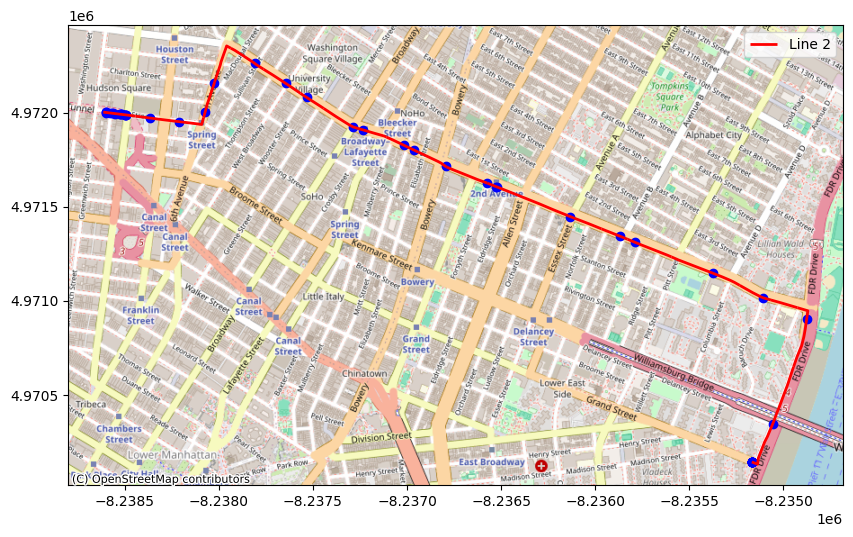

In [214]:
plot_points_lines(buses.query("unique_trip_id == @random_trip").sort_values(["timestamp"]), bus_segments, buses.query("unique_trip_id == @random_trip")["shape_id"].iloc[0])

In [215]:
test_trip = buses.query("unique_trip_id == @random_trip").sort_values(["position_on_line"])[["unique_trip_id", "shape_id", "timestamp", "position_on_line"]]

In [216]:
test_trip

,unique_trip_id,shape_id,timestamp,position_on_line
138155,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:27:49,31.099596
137216,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:23:49,31.099596
378607,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:18:49,41.763430
379575,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:22:49,95.082608
137920,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:26:49,116.241262
114173,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:17:49,135.470071
387469,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:30:19,156.797809
137684,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:25:19,220.781040
379331,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:21:19,220.781040
387242,MQ_D3-Weekday-SDon-129000_M9_65MTA NYCT_973920...,M210127,2023-09-19 01:29:19,231.444914


In [217]:
monotone_test = longest_increasing_subsequence(test_trip.sort_values("timestamp"))

In [218]:
shape_id = test_trip["shape_id"].iloc[0]
trip_segments = segments.query("shape_id == @shape_id")

In [220]:
monotone_test["epoch_timestamp"] = monotone_test["timestamp"].astype(int) // 10**9
trip_segments["interpolated_time"] = pd.to_datetime(np.round(np.interp(trip_segments["projected_position"], monotone_test["position_on_line"], monotone_test["epoch_timestamp"])), unit='s')

In [221]:
trip_segments["time_elapsed"] = trip_segments["interpolated_time"].diff().dt.total_seconds()
trip_segments["speed_mph"] = (trip_segments["segment_length"] / trip_segments["time_elapsed"]) * 0.681818

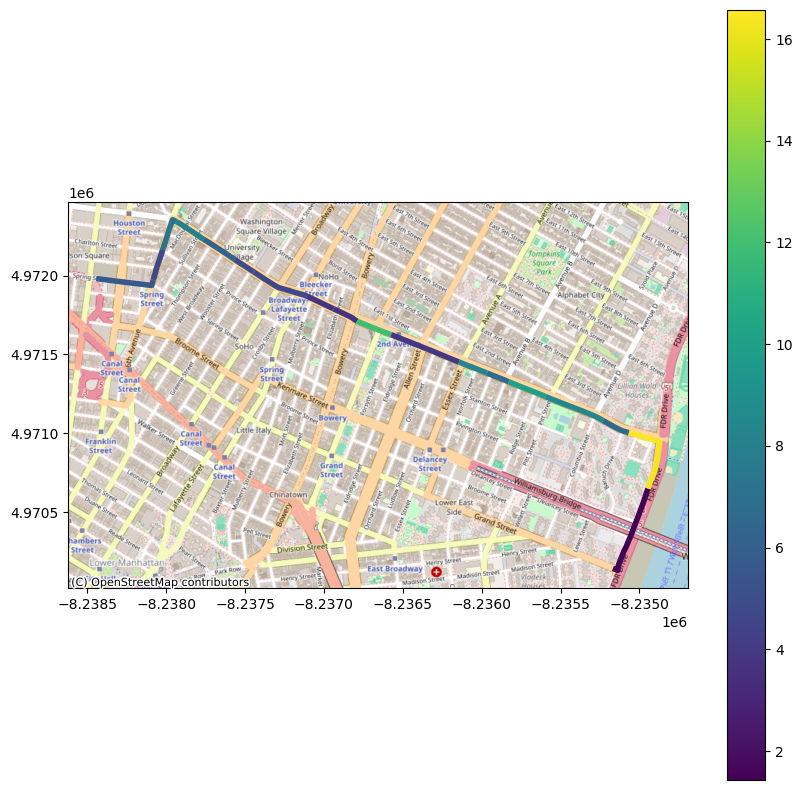

In [222]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot with linewidth and get the resulting plot to assign the colorbar
plot = segments.merge(trip_segments).to_crs(3857).plot(
    column="speed_mph", 
    ax=ax, 
    linewidth=4,  # Increase line width
    legend=True  # Enable the legend (colorbar)
)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [21]:
merged_stop_seq.merge(segments[["shape_id", "stop_sequence", "stop_id"]], how = "right").query("unique_trip_id.isna()")

,unique_trip_id,shape_id,timestamp,position_on_line,prev_projected_position,stop_sequence,prev_stop_id,stop_id
0,NaN,M090014,NaT,NaN,NaN,2,NaN,402048
1,NaN,M090014,NaT,NaN,NaN,3,NaN,402049
2,NaN,M090014,NaT,NaN,NaN,4,NaN,401832
3,NaN,M090014,NaT,NaN,NaN,5,NaN,405390
4,NaN,M090014,NaT,NaN,NaN,6,NaN,404264
...,...,...,...,...,...,...,...,...
5557,NaN,M110064,NaT,NaN,NaN,21,NaN,401413
5558,NaN,M110064,NaT,NaN,NaN,22,NaN,401414
5559,NaN,M110064,NaT,NaN,NaN,23,NaN,401416
5560,NaN,M110064,NaT,NaN,NaN,24,NaN,401417


In [64]:
import matplotlib.colors as mcolors

def plot_segment_speeds(segments, speeds, img_path=None, vmin=None, vmax=None):
    # Merge and project to Web Mercator
    gdf = segments.merge(speeds).to_crs(3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot with specified min and max values for the color scale
    gdf.plot(ax=ax, linewidth=3, column="speed_mph", cmap='viridis', vmin=vmin, vmax=vmax, legend=True)

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Save or show the plot
    if img_path is not None:
        plt.savefig(img_path)
        plt.close()  
    else:
        plt.show()


In [72]:
buses_with_segments['hour'] = pd.to_datetime(buses_with_segments['vehicle.timestamp']).dt.hour

In [ ]:
for hour in range(0, 24):
    print(hour)
    hourly_seg_speeds = buses_with_segments.query("hour == @hour").groupby(["from_node", "to_node"])["speed_mph"].mean().reset_index()
    plot_segment_speeds(m96_path, hourly_seg_speeds, img_path=f"plots/speed_hours/hour_{hour}_.png", vmin = 0, vmax = 25)

In [ ]:
buses_with_segments.query("hour == 10").groupby(["from_node", "to_node"])["speed_mph"].mean().reset_index()

In [ ]:
plot_segment_speeds(m96_path, seg_averages, img_path="speed_hours" vmin = 0, vmax = 25)

In [ ]:
25 / (78/60)

In [ ]:
45/(52/60)

In [ ]:
25 * (12/52)  + 60 * (40/52)

In [ ]:
10 * (30/78)  + 25 * (48/78)